# PyTorch Computer Vision Challenge - Fashion MNIST

In [63]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.3.0
0.18.0


## 1. Getting a dataset


In [64]:
# Setup training data: FashionMNIST images with corresponding labels
train_data = datasets.FashionMNIST(
    root="data",  # where to download the data to
    train=True,  # this is training data
    download=True,  # download if data not present
    transform=ToTensor(),  # convert the image data to a tensor
    target_transform=None,  # don't transform the labels/targets
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor(), target_transform=None
)

# Create a DataLoader to load the data in batches
# train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [65]:
len(train_data), len(test_data)

(60000, 10000)

In [66]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [67]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [68]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

### 1.2 Visualize the data


(-0.5, 27.5, 27.5, -0.5)

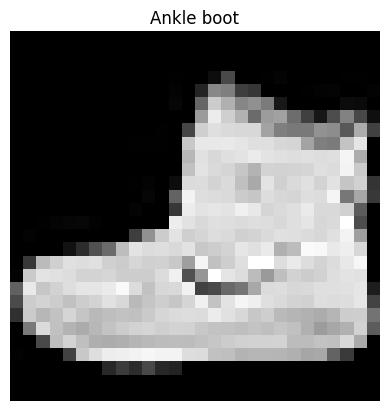

In [69]:
# Display the first image from the training set
plt.imshow(image.squeeze(), cmap="gray")
plt.title(train_data.classes[label])
plt.axis(False)

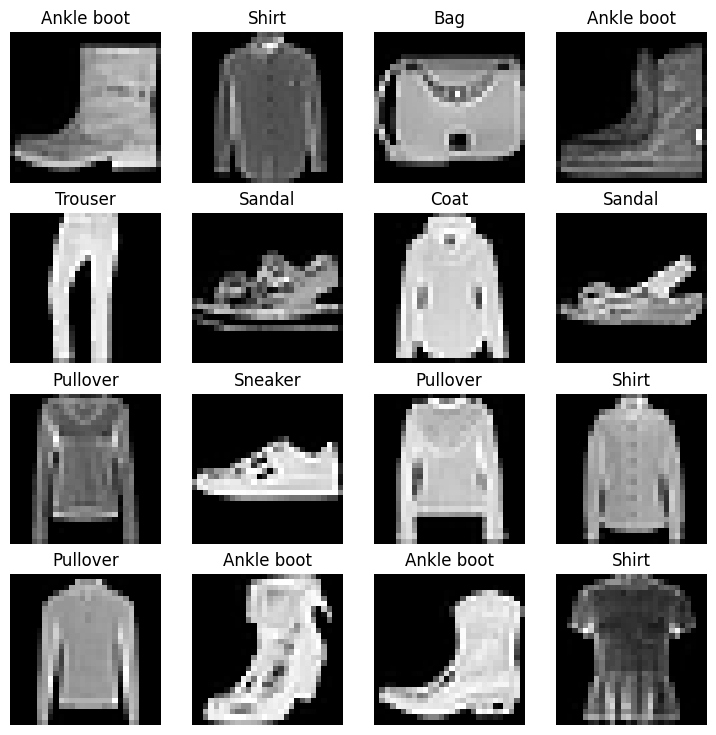

In [70]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    index = torch.randint(len(train_data), size=(1,)).item()
    image, label = train_data[index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False)

## 2. Prepare DataLoader

Pytorch Datasets can not be fed directly into the model. We need to convert the dataset into a DataLoader.

DataLoader turns datasets into a Python iterable. We can iterate over the DataLoader to get batches of data.

More specifically, DataLoader can turn a dataset into an iterable of batches (or mini-batches). We can specify the batch size and whether the data should be shuffled.

The reasons of using batches are:

1. **Efficiency**: We can't fit the entire dataset into the memory. So, we load a small batch of data, process it, and then load another batch. This way, we can train a model on a large dataset.
2. **Gradient Descent**: The neuron network will have more chances to update its gradients per epoch. This will lead to faster convergence.


In [71]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE: int = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x31b7a0690>,
 <torch.utils.data.dataloader.DataLoader at 0x31b6fd490>)

In [72]:
# Number of batches, the last batch will have fewer images
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [73]:
# Inside the training data loader
train_features_batch, train_labels_batch = next(
    iter(train_dataloader)
)  # next returns the next item from the iterator (in this case, the first batch)
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

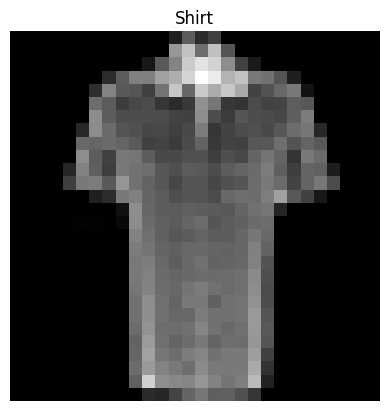

In [74]:
# Show a sample
torch.manual_seed(42)
rand_idx = torch.randint(len(train_features_batch), size=(1,)).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(train_data.classes[label])
plt.axis(False)

## 3. Model 0: Baseline Model

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.


In [75]:
flatten_model = nn.Flatten()  # this will flatten the input tensor to a 1D tensor
x = train_features_batch[0]
x_flat = flatten_model(x)
x.shape, x_flat.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [76]:
class FMNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int = 10):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape),
        )

    def forward(self, x):
        logits = self.layer_stack(x)
        return logits

In [77]:
torch.manual_seed(42)
model_0 = FMNISTModel(
    input_shape=28 * 28, hidden_units=10, output_shape=len(class_to_idx.keys())
).to("cpu")
model_0

FMNISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [78]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(
    dummy_x
).shape  # [1, 10] because we have 1 image and 10 classes to predict. The model will output the logits for each class

torch.Size([1, 10])

### 3.1 Set up loss function, optimizer, and evaluation metrics

-   Loss function - Multi-class so we use `nn.CrossEntropyLoss()`
-   Optimizer - `torch.optim.SGD()` (stochastic gradient descent)
-   Evaluation metric - Classification problem, so we will use accuracy


In [79]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

### 3.2 Creating a function to time the experiments

2 main things we want to measure:

1. Model's performance (loss and accuracy)
2. How fast it runs


In [80]:
from timeit import default_timer as timer


def print_train_time(start: float, end: float, device: torch.device = None) -> float:
    total_time = end - start
    print(f"Training time on {device if device else 'CPU'}: {total_time:.2f} seconds")
    return total_time

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss _per batch_
3. Loop through testing batches, perform testing steps, calculate the test loss and accuracy _per batch_
4. Print out what's happening
5. Time how long the model takes to train


In [81]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (full passes through the training data)
EPOCHS: int = 5

# Create training and testing loops
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch+1}\n-------------------------------")
    # Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Compute loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # Accumulate the training loss

        # 3. Zero the gradients
        optimizer.zero_grad()

        # 4. Compute gradients
        loss.backward()

        # 5. Update the model weights
        optimizer.step()

        # Print the loss every 100 batches
        if batch % 400 == 0:
            print(f"Batch {batch} Loss {loss.item()}")

    # Compute the average training loss per epoch
    train_loss /= len(train_dataloader)

    # Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X_test)
            # 2. Calculate the loss
            test_loss += loss_fn(test_pred, y_test).item()
            # 3. Calculate the accuracy
            test_acc += accuracy_fn(
                y_true=y_test, y_pred=test_pred.argmax(dim=1)
            )  # test_pred is the logits (For example, [0.1, 0.2, 0.7]) and we get the index of the highest value

        # Compute the average test loss and accuracy per epoch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(
        f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}"
    )

# Calculate the total training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(
    train_time_start_on_cpu,
    train_time_end_on_cpu,
    device=str(next(model_0.parameters()).device),
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Batch 0 Loss 2.366476535797119
Batch 400 Loss 0.6423891186714172
Batch 800 Loss 0.5696732401847839
Batch 1200 Loss 0.3812875747680664
Batch 1600 Loss 0.34902694821357727


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

Epoch 1, Train Loss: 0.5904, Test Loss: 0.5095, Test Accuracy: 82.0387
Epoch 2
-------------------------------
Batch 0 Loss 0.3799288272857666
Batch 400 Loss 0.6835905909538269
Batch 800 Loss 0.3863295316696167
Batch 1200 Loss 0.646413266658783
Batch 1600 Loss 0.26915842294692993


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

Epoch 2, Train Loss: 0.4763, Test Loss: 0.4799, Test Accuracy: 83.1969
Epoch 3
-------------------------------
Batch 0 Loss 0.3681364357471466
Batch 400 Loss 0.7437163591384888
Batch 800 Loss 0.29380080103874207
Batch 1200 Loss 0.39589783549308777
Batch 1600 Loss 0.37834492325782776


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

Epoch 3, Train Loss: 0.4550, Test Loss: 0.4766, Test Accuracy: 83.4265
Epoch 4
-------------------------------
Batch 0 Loss 0.3938825726509094
Batch 400 Loss 0.618492066860199
Batch 800 Loss 0.4464726448059082
Batch 1200 Loss 0.22020752727985382
Batch 1600 Loss 0.9585491418838501


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

Epoch 4, Train Loss: 0.4425, Test Loss: 0.4631, Test Accuracy: 83.7460
Epoch 5
-------------------------------
Batch 0 Loss 0.31807181239128113
Batch 400 Loss 0.4115495979785919
Batch 800 Loss 0.3512120842933655
Batch 1200 Loss 0.33535709977149963
Batch 1600 Loss 0.6142728924751282


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

Epoch 5, Train Loss: 0.4358, Test Loss: 0.4687, Test Accuracy: 83.2668
Training time on cpu: 13.17 seconds


## 4. Make predictions and get Model 0 results


In [82]:
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader


torch.manual_seed(42)


def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # 1. Forward pass
            y_pred = model(X)
            # 2. Calculate the loss value and accuracy
            loss += loss_fn(y_pred, y).item()
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "loss": loss,
        "accuracy": acc,
    }


# Calculate model 1 results on test dataset
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
model_0_results

100%|██████████| 313/313 [00:00<00:00, 1054.92it/s]


{'model_name': 'FMNISTModel',
 'loss': 0.4686939273588954,
 'accuracy': 83.2667731629393}

## 5. Setup device agnostic code


In [83]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 6. Build a better model with non-linear activation functions


In [84]:
class FMNISTModel1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int = 10):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = self.layer_stack(x)
        return logits

In [85]:
torch.manual_seed(42)
model_1 = FMNISTModel1(
    input_shape=28 * 28, hidden_units=128, output_shape=len(class_to_idx.keys())
).to(device)
next(model_1.parameters()).device

device(type='cpu')

### 6.1 Loss, optimizer, and evaluation metric


In [86]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

### 6.2 Functioning training loop and evaluation/testing loops

-   Training loop - `train_step()`
-   Testing loop - `test_step()`


In [87]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = torch.device("cpu"),
) -> None:
    """
    Perform a single training step (forward pass, loss computation, backward pass, weight update) for a PyTorch model
    """
    # Training and validation steps
    train_loss, train_acc = 0, 0
    # Set the model to training mode
    model.train()
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)

        # 2. Compute loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # Accumulate the training loss
        train_acc += accuracy_fn(
            y_true=y, y_pred=y_pred.argmax(dim=1)
        )  # logits to prediction labels

        # 3. Zero the gradients
        optimizer.zero_grad()

        # 4. Compute gradients
        loss.backward()

        # 5. Update the model weights
        optimizer.step()

    # Compute the average training loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train Loss: {train_loss:.5f}, Train Accuracy: {train_acc:.5f}")

In [88]:
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = torch.device("cpu"),
) -> None:
    """
    Perform a single evaluation step (forward pass, loss computation, accuracy computation) for a PyTorch model
    """
    # Testing steps
    test_loss, test_acc = 0, 0
    # Set the model to evaluation mode
    model.eval()
    # Turn on inference mode to disable gradient computation
    with torch.inference_mode():
        for X, y in data_loader:
            # Put data on target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculate the loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        # 3. Compute the average test loss and accuracy per epoch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.5f}")

In [89]:
torch.manual_seed(42)

# Measure time
train_time_start_on_device = timer()

# Set epochs
EPOCHS: int = 5

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_step(
        model=model_1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
    )
    test_step(
        model=model_1,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
    )
train_time_end_on_device = timer()
total_train_time_model_1 = print_train_time(
    train_time_start_on_device, train_time_end_on_device, device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train Loss: 0.69011, Train Accuracy: 76.99500


 20%|██        | 1/5 [00:02<00:11,  2.97s/it]

Test Loss: 0.46069, Test Accuracy: 83.58626
Epoch 2
-------------------------------
Train Loss: 0.41669, Train Accuracy: 84.85667


 40%|████      | 2/5 [00:05<00:08,  2.96s/it]

Test Loss: 0.42261, Test Accuracy: 84.81430
Epoch 3
-------------------------------
Train Loss: 0.37521, Train Accuracy: 86.41333


 60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

Test Loss: 0.38797, Test Accuracy: 86.26198
Epoch 4
-------------------------------
Train Loss: 0.34881, Train Accuracy: 87.30167


 80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

Test Loss: 0.37485, Test Accuracy: 86.65136
Epoch 5
-------------------------------
Train Loss: 0.33144, Train Accuracy: 87.87000


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

Test Loss: 0.37188, Test Accuracy: 86.87101
Training time on cpu: 14.91 seconds


> **Note** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.
>
> Why is this?
>
> 1. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU.
> 2. The hardware you're using has a better CPU in terms of compute performance than the GPU.


In [90]:
model_0_results

{'model_name': 'FMNISTModel',
 'loss': 0.4686939273588954,
 'accuracy': 83.2667731629393}

In [91]:
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader


torch.manual_seed(42)


def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            y_pred = model(X)
            # 2. Calculate the loss value and accuracy
            loss += loss_fn(y_pred, y).item()
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "loss": loss,
        "accuracy": acc,
    }

In [92]:
model_1_results = eval_model(
    model_1, test_dataloader, loss_fn, accuracy_fn, device=device
)
model_1_results

100%|██████████| 313/313 [00:00<00:00, 924.97it/s]


{'model_name': 'FMNISTModel1',
 'loss': 0.37187641992355686,
 'accuracy': 86.87100638977635}

## Convolutional Neural Networks (CNNs)

CNN's are also known ConvNets.

CNN's are known for their effectiveness in image classification tasks.


In [93]:
import torch
from torch import nn


class FMNISTModelCNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 7 * 7,
                out_features=output_shape,
            ),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

In [94]:
torch.manual_seed(42)
model_2 = FMNISTModelCNN(
    input_shape=1,  # Number of color channels
    hidden_units=10,  # Number of filters in the convolutional layer
    output_shape=len(class_to_idx.keys()),  # Number of classes
).to(device)

### Set up loss function, optimizer, and evaluation metric


In [95]:
# Set the loss function and optimizer for model CNN
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

# Set epochs
EPOCHS: int = 3

# Measure time
train_time_start_on_device = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_step(
        model=model_2,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
    )
    test_step(
        model=model_2,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
    )
train_time_end_on_device = timer()
total_train_time_model_2 = print_train_time(
    train_time_start_on_device, train_time_end_on_device, device=device
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train Loss: 0.57823, Train Accuracy: 79.12167


 33%|███▎      | 1/3 [00:33<01:06, 33.46s/it]

Test Loss: 0.39129, Test Accuracy: 85.78275
Epoch 2
-------------------------------
Train Loss: 0.35654, Train Accuracy: 87.11333


 67%|██████▋   | 2/3 [01:07<00:33, 33.67s/it]

Test Loss: 0.36998, Test Accuracy: 85.95248
Epoch 3
-------------------------------
Train Loss: 0.31761, Train Accuracy: 88.54833


100%|██████████| 3/3 [01:41<00:00, 33.68s/it]

Test Loss: 0.32205, Test Accuracy: 88.55831
Training time on cpu: 101.03 seconds


In [96]:
model_2_results = eval_model(
    model_2, test_dataloader, loss_fn, accuracy_fn, device=device
)
model_2_results

100%|██████████| 313/313 [00:01<00:00, 249.95it/s]


{'model_name': 'FMNISTModelCNN',
 'loss': 0.32204896040236985,
 'accuracy': 88.55830670926518}

In [97]:
import pandas as pd

compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results["training_time"] = [
    total_train_time_model_0,
    total_train_time_model_1,
    total_train_time_model_2,
]
compare_results

,model_name,loss,accuracy,training_time
0,FMNISTModel,0.468694,83.266773,13.170183
1,FMNISTModel1,0.371876,86.871006,14.910181
2,FMNISTModelCNN,0.322049,88.558307,101.033752


Text(0.5, 1.0, 'Comparison of Model Accuracy on Fashion MNIST')

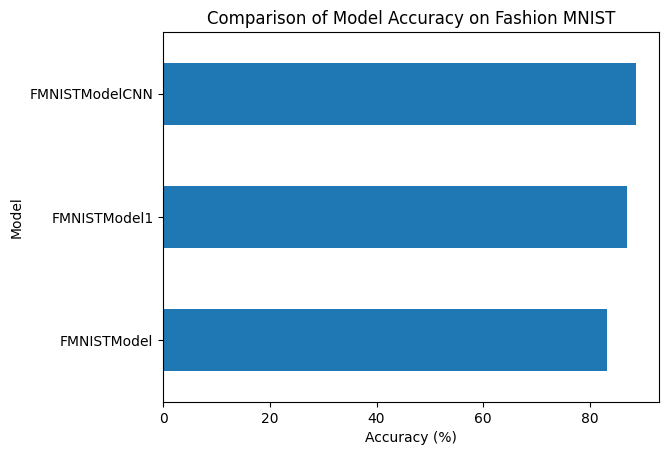

In [98]:
# Visualize our model results

compare_results.set_index("model_name")["accuracy"].plot(kind="barh")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.title("Comparison of Model Accuracy on Fashion MNIST")

In [99]:
def make_preds(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X in data:
            # Prepare the sample (add a batch dimension and move to target device)
            X = torch.unsqueeze(X, dim=0).to(device)
            # Forward pass (mdel outputs raw logits)
            y_pred = model(X)
            # Get the predicted class probabilities (logits to probabilities)
            pred_prob = torch.softmax(y_pred.squeeze(), dim=0)
            # Get pred_prob off the device and append to the list
            pred_probs.append(pred_prob.cpu())

    # Stack the probs to turn the list into a tensor
    return torch.stack(pred_probs)

In [100]:
import random

random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape, test_labels[0]

(torch.Size([1, 28, 28]), 5)

In [101]:
pred_probs = make_preds(model_2, test_samples, device=device)
# Convert the predicted probabilities to predicted class labels
pred_labels = pred_probs.argmax(dim=1)
pred_labels

tensor([5, 0, 7, 4, 3, 0, 4, 7, 1])

In [102]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

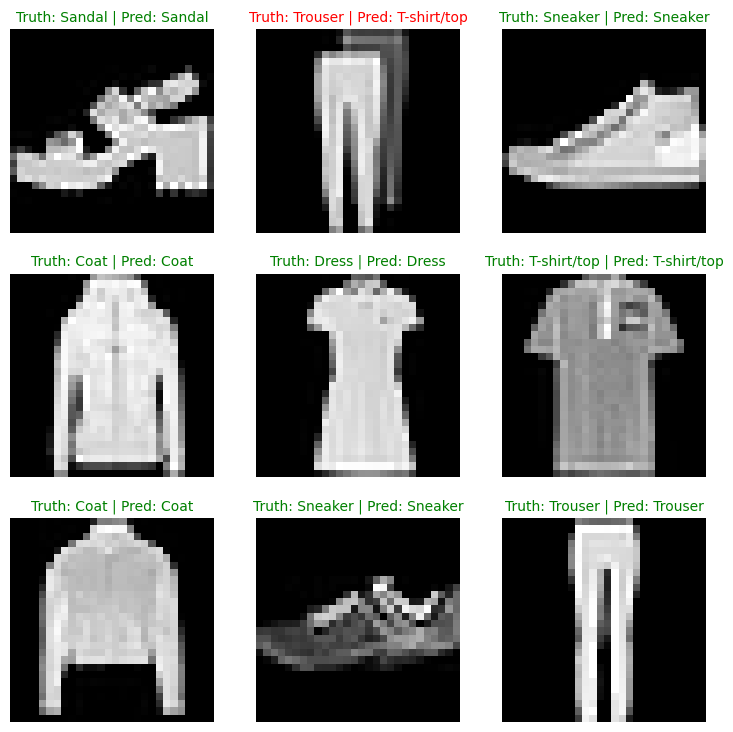

In [108]:
plt.figure(figsize=(9, 9))
nrows = ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = test_data.classes[pred_labels[i]]
    truth_label = test_data.classes[test_labels[i]]
    title_txt = f"Truth: {truth_label} | Pred: {pred_label}"
    if pred_label == truth_label:
        plt.title(title_txt, fontdict={"color": "green", "fontsize": 10})
    else:
        plt.title(title_txt, fontdict={"color": "red", "fontsize": 10})
    plt.axis(False)

## Confusion Matrix for further evaluation

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix(num_classes=n)`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`


In [112]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send data to device
        X, y = X.to(device), y.to(device)
        # Get model predictions
        y_logit = model_2(X)
        # Get predicted class label (logits to probabilities to class labels)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(
            dim=1
        )  # softmax to get probabilities and argmax to get the class label
        # Put the predicted labels on the CPU for evaluation
        y_preds.append(y_pred.cpu())

print(y_preds)
y_pred_tensor = torch.cat(y_preds)

Making predictions...: 100%|██████████| 313/313 [00:01<00:00, 205.46it/s]

[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 6, 8, 0, 2, 5, 7, 5,
        1, 6, 6, 0, 9, 3, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 2, 6, 4, 2, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5]), tensor([1, 1, 3, 3, 7, 8, 7, 0, 2, 6, 4, 3, 1, 2, 8, 4, 3, 8, 5, 9, 5, 0, 3, 2,
        0, 6, 5, 3, 6, 7, 1, 8]), tensor([6, 1, 2, 2, 3, 6, 7, 6, 7, 8, 5, 7, 9, 4, 2, 5, 7, 6, 5, 2, 8, 6, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 2]), tensor([1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 6, 0, 0, 1, 6, 1, 3, 2, 2, 2, 4,
        1, 4, 5, 6, 4, 7, 9, 3]), tensor([7, 2, 3, 8, 0, 9, 4, 7, 8, 8, 6, 5, 2, 1, 2, 1, 3, 8, 8, 1, 0, 9, 3, 6,
        7, 9, 8, 4, 4, 7, 1, 2]), tensor([3, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 5, 2, 6, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        1, 6, 7, 2, 8, 5, 6, 0]), tensor([7, 7, 6, 6, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 3, 2, 5, 4, 9, 2, 2, 8, 6, 4,
        6, 4, 9, 7, 3, 5, 5, 4]), tensor([8, 5, 2, 3, 0, 4, 8, 6, 0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 4,
       

In [110]:
len(y_pred_tensor)

10000

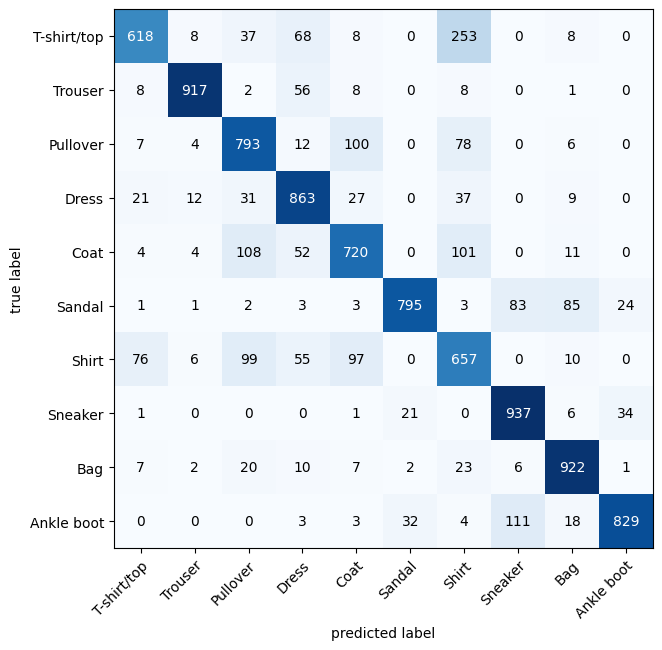

In [118]:
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Set up the confusion matrix and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_to_idx.keys()), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=test_data.classes,
    figsize=(10, 7),
)

## Save and load the model


In [120]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "03_pytorch_computer_vision_model_CNN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model state dict at: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

Saving model state dict at: models/03_pytorch_computer_vision_model_CNN.pth


In [121]:
# Create a new model instance
torch.manual_seed(42)
loaded_model_2 = FMNISTModelCNN(
    input_shape=1, hidden_units=10, output_shape=len(class_to_idx.keys())
)

# Load the model state dict
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the loaded model to the device
loaded_model_2.to(device)

FMNISTModelCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [122]:
model_2_results

{'model_name': 'FMNISTModelCNN',
 'loss': 0.32204896040236985,
 'accuracy': 88.55830670926518}

In [123]:
# Evaluate the loaded model
loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device,
)
loaded_model_2_results

100%|██████████| 313/313 [00:01<00:00, 236.39it/s]


{'model_name': 'FMNISTModelCNN',
 'loss': 0.32204896040236985,
 'accuracy': 88.55830670926518}

In [125]:
# Check if model results are the same
torch.allclose(
	torch.tensor(model_2_results["loss"]),
	torch.tensor(loaded_model_2_results["loss"]),
	atol=1e-08,
)

True